Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

## Autoregression

$$\hat{y} = b_0 + b_1X_1$$

A regression model, such as linear regression, models an output value based on a linear combination of input values.

Where,
$\hat{y}$, is the prediction. $b_0$ and $b_1$ are coefficients found by optimizing the model on training data, and X is an input value.

This technique can be used on time series where input variables are taken as observations at previous time steps, called lag variables.

For example, we can predict the value for the next time step (t+1) given 
the observations at the current (t and previous t-1).
$$ X_{t + 1} = b_0 + (b_1 X_t) + (b_2X_{t-1})$$

## Autocorrelation

The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on 
that variable when modeling. Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. It is also called serial correlation because of the sequenced structure of time series data.


In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [2]:
temp = pd.read_csv(r"./Datasets/daily-min-temperatures.csv",index_col=0)

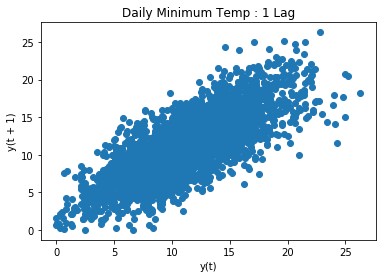

In [3]:
_ = pd.plotting.lag_plot(temp,1).set(title='Daily Minimum Temp : 1 Lag')

In [4]:
# Correlation : Spearmand and Pearson
ts  = pd.concat([temp,temp.shift(-1)],1).dropna()
ts.columns = ['t','t+1']

In [5]:
pearson_corr = ts.corr(method='pearson').values[0][1] # by default
spearman_corr = ts.corr(method='spearman').values[0][1] # by default
print("Pearson corr  :{:.3f}".format(pearson_corr))
print("Spearman corr :{:.3f}".format(spearman_corr))

Pearson corr  :0.775
Spearman corr :0.774


# Auto-correlation plots

The plot also includes solid and dashed lines that indicate the 95% and 99% 
confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

note: stats model also has acf plot.

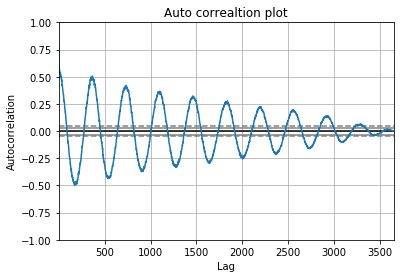

In [6]:
_  = pd.plotting.autocorrelation_plot(ts['t']).set(title='Auto correaltion plot')

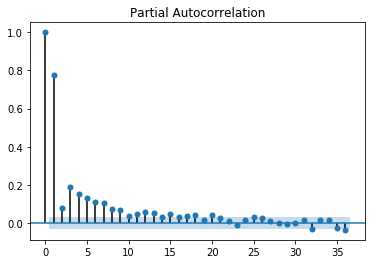

In [7]:
plot_pacf(ts['t']);

In [8]:
# persistance model
# we will use previous day value as forecast
# for current day
train,test = ts.iloc[:-7],ts.iloc[-7:]
print("Len of train sample ",len(train))
print("Len of test sample " ,len(test))

Len of train sample  3642
Len of test sample  7


In [9]:
obs = test['t+1']
pre = test['t']

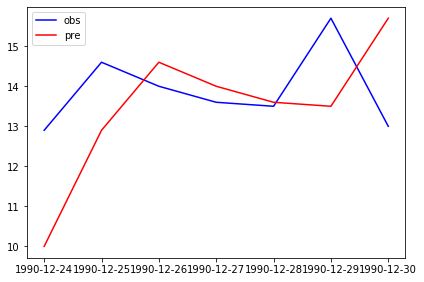

In [10]:
plt.plot(obs,color='b')
plt.plot(pre,color='r')
plt.legend(['obs','pre'])
plt.tight_layout(True)

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
rmse = pd.np.sqrt(mean_squared_error(obs,pre))
print("RMSE : {:.3f}".format(rmse))

RMSE : 1.850


In [13]:
## Auto-Regressive Model

In [14]:
from statsmodels.tsa.arima_model import ARMA

In [15]:
from statsmodels.tsa.ar_model import AR 

In [16]:
fit = AR(temp['Temp']).fit()

C:\Users\91882\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:\

In [17]:
lags = fit.k_ar
print("Lags ",lags)
print("coefficients :\n",fit.params.values)

Lags  29
coefficients :
 [ 5.58473579e-01  5.88308642e-01 -9.07900115e-02  4.82774649e-02
  3.99787077e-02  3.93799257e-02  2.54750298e-02  4.54344296e-02
  1.30253650e-02  3.69032153e-02 -1.52416557e-04  4.52698234e-03
  1.84649547e-02  2.64316760e-02  8.22885101e-04  2.41530815e-02
  7.33325171e-03  9.63511009e-03  3.50123451e-02 -9.33239273e-03
  2.43434209e-02  1.90687862e-02  1.21532725e-02 -1.80188951e-02
 -1.88364903e-03  1.69314228e-02  1.95542335e-02  1.00868071e-02
  5.76016621e-03 -1.59924009e-03]


In [18]:
# forecasting using AR model

In [19]:
# start = (pd.to_datetime(test.index.min()) + pd.offsets.Day()).strftime("%Y-%m-%d")
# end = (pd.to_datetime(test.index.max()) + pd.offsets.Day()).strftime("%Y-%m-%d")
start = temp.index[-7] ; end = temp.index[-1]
predicted = fit.predict(start,end)

In [20]:
df = pd.concat([predicted,temp['Temp'].iloc[-7:]],1,keys=['Predicted','Expected'])
print(df.to_string())

            Predicted  Expected
Date                           
1990-12-25  11.883003      12.9
1990-12-26  13.668638      14.6
1990-12-27  14.352896      14.0
1990-12-28  13.435128      13.6
1990-12-29  13.375858      13.5
1990-12-30  13.488215      15.7
1990-12-31  14.757591      13.0


[Text(0.5, 0, '')]

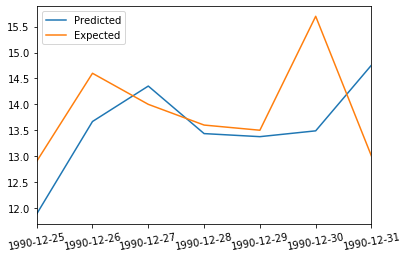

In [21]:
df.plot(rot=10).set(xlabel='')

In [22]:
rmse = pd.np.sqrt(mean_squared_error(df['Predicted'],df['Expected']))

In [23]:
print("RMSE : {:.3f} ".format(rmse))

RMSE : 1.198 


In [39]:
from statsmodels.tsa.ar_model import AutoReg
fit_ar = AutoReg(temp['Temp'],lags=29,period=1).fit()
print("Params",fit_ar.params.values)
## AR is now depreciated from 0.11 onwards
## we can use AutoReg, which is basically the same

Params [ 5.58473579e-01  5.88308642e-01 -9.07900115e-02  4.82774649e-02
  3.99787077e-02  3.93799257e-02  2.54750298e-02  4.54344296e-02
  1.30253650e-02  3.69032153e-02 -1.52416557e-04  4.52698234e-03
  1.84649547e-02  2.64316760e-02  8.22885101e-04  2.41530815e-02
  7.33325171e-03  9.63511009e-03  3.50123451e-02 -9.33239273e-03
  2.43434209e-02  1.90687862e-02  1.21532725e-02 -1.80188951e-02
 -1.88364903e-03  1.69314228e-02  1.95542335e-02  1.00868071e-02
  5.76016621e-03 -1.59924009e-03]


C:\Users\91882\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [38]:
AutoReg?

## Summary
- About autocorrelation and autoregression and how they can be used to better understand time series data.
- How to explore the autocorrelation in a time series using plots and statistical tests.
- How to train an autoregression model in Python and use it to make short-term and rolling forecasts.